# Scheduling Patterns

The goal of this is to preprocess the data of lesson requests, convert them into schedules, which would be used (by *code/main.py*) for generating a model that predicts when students will happen.

In [1]:
import pandas as pd
from dateutil.parser import parse
import pylab as pl
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import re

from scipy.stats import chi2_contingency

import sys, os

sys.path.append(os.path.join(os.getcwd(), 'code'))

from backtest import BackTest
from models import DumbModel, SmartHeuristicModel

%matplotlib inline


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
name = 'data/export_lesson_requests_2016_09_08.pkl'
lesson_request_data = pkl.load(open(name, 'rb'))

In [3]:
lesson_request_data

,user_id,lr_start_datetime,lr_id,user_tz,company_name,cr_id
225,48,2014-08-25 22:00:00-03:00,24892,Brasilia,all_students,NaN
227,48,2014-08-27 00:00:00-03:00,24893,Brasilia,all_students,NaN
229,48,2014-09-01 22:00:00-03:00,24894,Brasilia,all_students,NaN
231,48,2014-09-04 00:00:00-03:00,24895,Brasilia,all_students,NaN
233,48,2014-09-10 18:00:00-03:00,24896,Brasilia,all_students,NaN
235,48,2014-09-22 22:00:00-03:00,24898,Brasilia,all_students,NaN
237,48,2014-09-29 22:00:00-03:00,24899,Brasilia,all_students,NaN
239,48,2015-01-20 11:00:00-02:00,24897,Brasilia,all_students,NaN
241,48,2015-02-17 11:00:00-02:00,1793,Brasilia,all_students,NaN
243,48,2015-02-18 11:00:00-02:00,1794,Brasilia,all_students,NaN


In [4]:
# scale day of week to [0,1]
lesson_request_data['scaled_weekday'] = lesson_request_data['lr_start_datetime']\
    .apply(lambda x: x.weekday() / 6.0)
# scale start_time to [0,1]
lesson_request_data['scaled_start_time'] = lesson_request_data['lr_start_datetime']\
    .apply(lambda x: (x.hour + (x.minute / 60.0)) / 23.75)
lesson_request_data['weekday'] = lesson_request_data['lr_start_datetime']\
    .apply(lambda x: x.weekday())
lesson_request_data['start_time'] = lesson_request_data['lr_start_datetime']\
    .apply(lambda x: (x.hour + (x.minute / 60.0)))

In [5]:
columns = lesson_request_data.columns

In [6]:
lesson_request_data[lesson_request_data.user_tz.isnull()].count()

user_id              615
lr_start_datetime    615
lr_id                615
user_tz                0
company_name         615
cr_id                 12
scaled_weekday       615
scaled_start_time    615
weekday              615
start_time           615
dtype: int64

In [7]:
lesson_request_data.groupby('user_tz').size().sort_values(ascending=False)

user_tz
Pacific Time (US & Canada)     20128
Brasilia                       15105
Tokyo                          10650
Eastern Time (US & Canada)      7299
Buenos Aires                    3822
Mexico City                     3425
London                          3234
Central Time (US & Canada)      2366
Bogota                          1996
Jerusalem                       1389
Seoul                           1136
Paris                           1122
Vienna                          1017
Mountain Time (US & Canada)      906
Madrid                           777
Dublin                           732
Arizona                          669
Hong Kong                        629
Berlin                           498
Guadalajara                      352
New Delhi                        344
Rome                             341
Singapore                        280
Monterrey                        272
Mumbai                           256
Beijing                          202
Osaka                         

In [8]:
lesson_request_data.groupby('company_name').size().sort_values(ascending=False)

company_name
all_students    81003
dtype: int64

In [9]:
lesson_request_data[lesson_request_data.user_tz.isnull()].sample(20)[columns]

,user_id,lr_start_datetime,lr_id,user_tz,company_name,cr_id,scaled_weekday,scaled_start_time,weekday,start_time
4007,378,2014-09-24 17:00:00.202000,24677,NaN,all_students,NaN,0.333333,0.715789,2,17.00
4010,378,2014-10-15 20:00:00.381080,24649,NaN,all_students,NaN,0.333333,0.842105,2,20.00
644,296,2014-05-26 16:00:00.221951,27424,NaN,all_students,NaN,0.000000,0.673684,0,16.00
3574,362,2014-09-23 01:00:00.357024,24871,NaN,all_students,NaN,0.166667,0.042105,1,1.00
922,340,2014-06-11 20:00:00.444528,27590,NaN,all_students,NaN,0.333333,0.842105,2,20.00
634,296,2014-04-15 20:00:00.992919,27411,NaN,all_students,NaN,0.166667,0.842105,1,20.00
8892,764,2014-07-17 15:00:00.155481,26151,NaN,all_students,NaN,0.500000,0.631579,3,15.00
4017,378,2014-12-17 19:00:00.541875,24666,NaN,all_students,NaN,0.333333,0.800000,2,19.00
906,340,2014-05-14 23:00:00.657167,27595,NaN,all_students,NaN,0.333333,0.968421,2,23.00
3981,376,2014-03-13 02:00:00.251377,27320,NaN,all_students,NaN,0.500000,0.084211,3,2.00


In [10]:
lesson_request_data[lesson_request_data.user_tz.isnull()]['lr_start_datetime'].max()

datetime.datetime(2016, 8, 15, 17, 15)

In [11]:
# 36 affected with missing user_tz
lesson_request_data[lesson_request_data.user_tz.isnull()].groupby('user_id').size().index.size

88

In [12]:
# 1,663 have valid user_tz
lesson_request_data[lesson_request_data.user_tz.notnull()].groupby('user_id').size().index.size

1656

In [109]:
null_lr = lesson_request_data[lesson_request_data.user_tz.isnull()]
null_lr.columns

Index([u'user_id', u'lr_start_datetime', u'lr_id', u'user_tz', u'company_name',
       u'cr_id', u'scaled_weekday', u'scaled_start_time', u'weekday',
       u'start_time'],
      dtype='object')

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


yr    mo
2014  2       1
      3     134
      4      84
      5      69
      6      72
      7      73
      8      40
      9      50
      10     37
      11     14
      12     11
2015  1      12
      2       5
2016  7       7
      8       6
dtype: int64

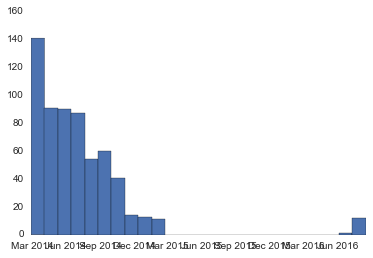

In [114]:
# Most user_tz issues were before March 2015. There is a few in 2016, not really sure why.
# If student has already a lesson request, this should mean that they already had filled out the registration process, 
# which means that they should have been able to put in timezone info.
fig = null_lr['lr_start_datetime'].hist(bins=25)
#null_lr.groupby('lr_start_datetime').size()
null_lr['yr'] = null_lr['lr_start_datetime'].apply(lambda x: x.year)
null_lr['mo'] = null_lr['lr_start_datetime'].apply(lambda x: x.month)
null_lr.groupby(['yr', 'mo']).size()
#null_lr['lr_start_datetime'].hist()
#fig.set_title('Num LRs Missing Timezone')
#print fig.get_xlabel()
#fig.set_xticklabels(fig.get_xlabel(),rotation=45, rotation_mode="anchor", ha="right")
#fig.set_xlabel(fig.get_xlabel(), rotation=45)

In [104]:
all_students_df = lesson_request_data[lesson_request_data['company_name'] == 'all_students']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112151950>]], dtype=object)

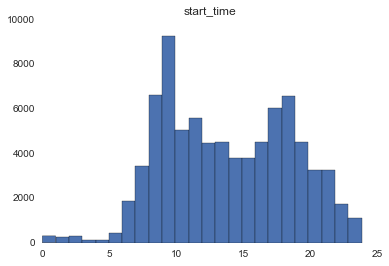

In [16]:
all_students_df[all_students_df.user_id.notnull()].hist(column=['start_time'], bins=24)

In [17]:
all_students_df.head(5)

,user_id,lr_start_datetime,lr_id,user_tz,company_name,cr_id,scaled_weekday,scaled_start_time,weekday,start_time
225,48,2014-08-25 22:00:00-03:00,24892,Brasilia,all_students,NaN,0.000000,0.926316,0,22.0
227,48,2014-08-27 00:00:00-03:00,24893,Brasilia,all_students,NaN,0.333333,0.000000,2,0.0
229,48,2014-09-01 22:00:00-03:00,24894,Brasilia,all_students,NaN,0.000000,0.926316,0,22.0
231,48,2014-09-04 00:00:00-03:00,24895,Brasilia,all_students,NaN,0.500000,0.000000,3,0.0
233,48,2014-09-10 18:00:00-03:00,24896,Brasilia,all_students,NaN,0.333333,0.757895,2,18.0


In [18]:
all_students_df.sample(5)[['user_id', 'lr_start_datetime', 'lr_id', 'cr_id', 'company_name']]

,user_id,lr_start_datetime,lr_id,cr_id,company_name
118349,2193,2016-07-21 12:30:00-04:00,97154,NaN,all_students
115411,2096,2016-01-04 17:00:00-07:00,51903,28056,all_students
170587,2900,2016-09-16 11:30:00+01:00,121950,NaN,all_students
86754,1678,2015-10-01 15:00:00+09:00,37369,NaN,all_students
49267,1324,2015-04-29 10:00:00-04:00,9891,2459,all_students


In [19]:
all_students_df.describe()

,scaled_weekday,scaled_start_time,weekday,start_time
count,81003.000000,81003.000000,81003.000000,81003.000000
mean,0.361799,0.569854,2.170796,13.534035
std,0.264637,0.201893,1.587820,4.794957
min,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.378947,1.000000,9.000000
50%,0.333333,0.547368,2.000000,13.000000
75%,0.500000,0.757895,3.000000,18.000000
max,1.000000,1.003509,6.000000,23.833333


In [20]:
not_null_user_tz = all_students_df[all_students_df.user_tz.notnull()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ace8810>]], dtype=object)

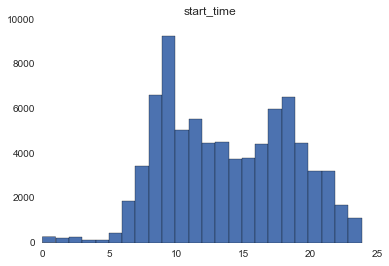

In [21]:
not_null_user_tz.hist(column=['start_time'], bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110ab4910>]], dtype=object)

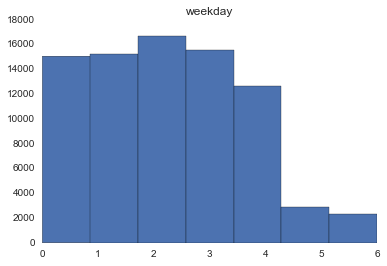

In [22]:
not_null_user_tz.hist(column=['weekday'], bins=7)

In [23]:
not_null_user_tz.lr_start_datetime.min()

datetime.datetime(2014, 3, 4, 12, 0, tzinfo=tzoffset(None, -25200))

In [80]:
def hexbin_user_tz(df, timezone):
    return df[df.user_tz == timezone].plot.hexbin(x='weekday', 
                                           y='start_time', 
                                           title='{} LRs'.format(timezone),  
                                           gridsize=24, sharex=False).legend(['hi'])

In [81]:
not_null_user_tz.lr_start_datetime.max()

datetime.datetime(2016, 11, 29, 9, 0, tzinfo=tzoffset(None, -28800))

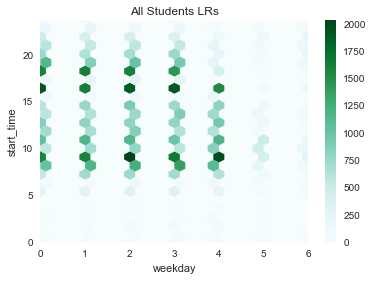

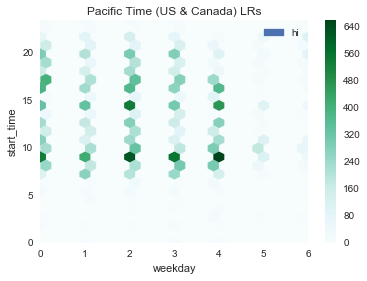

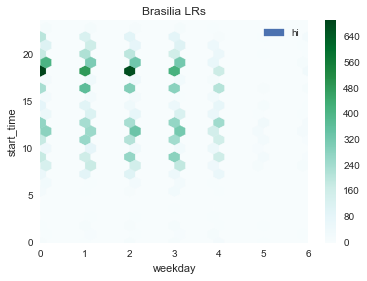

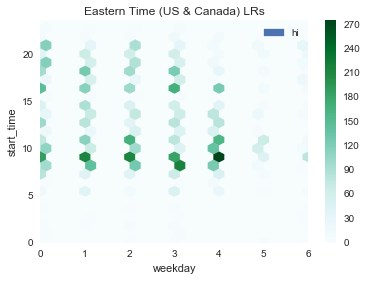

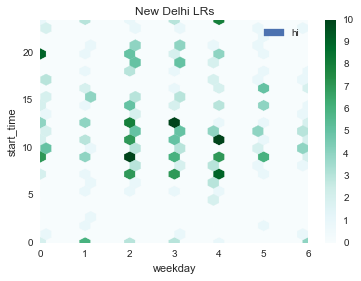

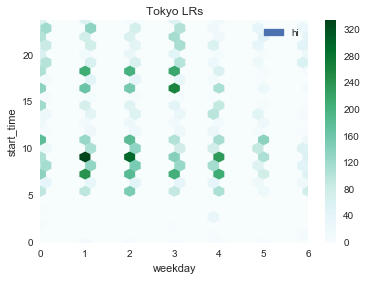

In [82]:
# Another way to see that...
# 1. Most of lessons start between 8 AM and 8PM
# 2. Peaks are around 8-10 AM and 4-6 PM
all_students_df.plot.hexbin(x='weekday', y='start_time', title='All Students LRs', gridsize=24, sharex=False)
for i in ['Pacific Time (US & Canada)','Brasilia', 'Eastern Time (US & Canada)', 'New Delhi',  'Tokyo']:
    hexbin_user_tz(all_students_df, i)

In [27]:
all_students_df

,user_id,lr_start_datetime,lr_id,user_tz,company_name,cr_id,scaled_weekday,scaled_start_time,weekday,start_time
225,48,2014-08-25 22:00:00-03:00,24892,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
227,48,2014-08-27 00:00:00-03:00,24893,Brasilia,all_students,NaN,0.333333,0.000000,2,0.000000
229,48,2014-09-01 22:00:00-03:00,24894,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
231,48,2014-09-04 00:00:00-03:00,24895,Brasilia,all_students,NaN,0.500000,0.000000,3,0.000000
233,48,2014-09-10 18:00:00-03:00,24896,Brasilia,all_students,NaN,0.333333,0.757895,2,18.000000
235,48,2014-09-22 22:00:00-03:00,24898,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
237,48,2014-09-29 22:00:00-03:00,24899,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
239,48,2015-01-20 11:00:00-02:00,24897,Brasilia,all_students,NaN,0.166667,0.463158,1,11.000000
241,48,2015-02-17 11:00:00-02:00,1793,Brasilia,all_students,NaN,0.166667,0.463158,1,11.000000
243,48,2015-02-18 11:00:00-02:00,1794,Brasilia,all_students,NaN,0.333333,0.463158,2,11.000000


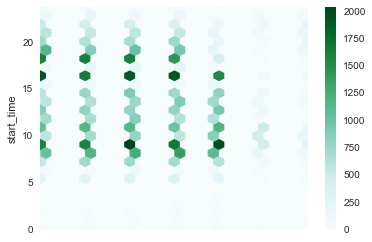

In [28]:
# Another way to see that...
# 1. Most of lessons start between 8 AM and 8PM
# 2. Peaks are around 8-10 AM and 4-6 PM
all_students_df.plot.hexbin(x='weekday', y='start_time', gridsize=24)

In [29]:
all_students_df.groupby('user_tz').size().sort_values(ascending=False)

user_tz
Pacific Time (US & Canada)     20128
Brasilia                       15105
Tokyo                          10650
Eastern Time (US & Canada)      7299
Buenos Aires                    3822
Mexico City                     3425
London                          3234
Central Time (US & Canada)      2366
Bogota                          1996
Jerusalem                       1389
Seoul                           1136
Paris                           1122
Vienna                          1017
Mountain Time (US & Canada)      906
Madrid                           777
Dublin                           732
Arizona                          669
Hong Kong                        629
Berlin                           498
Guadalajara                      352
New Delhi                        344
Rome                             341
Singapore                        280
Monterrey                        272
Mumbai                           256
Beijing                          202
Osaka                         

In [30]:
def get_student_df(df, user_id, num_to_return):
    return df[df.user_id==user_id].head(num_to_return)

In [31]:
def weekday_start_time(df, weekday_index):
    # need to get frequency of weekday
    relevant_df = df[df.weekday == weekday_index]
    return relevant_df.start_time.value_counts().argmax()



In [32]:
def keep_strongest_signal(df):

    size = df.groupby(['weekday', 'start_time']).size()
    return (size / size.max()).round()

In [33]:
temp = keep_strongest_signal(get_student_df(all_students_df, 1000, 20))
temp

Series([], dtype: float64)

In [34]:
temp.index.values

array([], dtype=object)

In [35]:
def convert_to_lesson_request_features(series):
    dictionary = {}
    time_values = []
    day_values = []
    
    # Initialize lesson variables (time and day)
    for i in range(1,8):
        dictionary['l{}_time'.format(i)] = None
        dictionary['l{}_day'.format(i)] = None
    
    counter = 1
    for wd, time in series.index:
        value = series[wd][time]
        if value == 1:
            time_desc = 'l{}_time'.format(counter)
            day_desc = 'l{}_day'.format(counter)
            
            dictionary[time_desc] = time  # set time for current lesson request 
            dictionary[day_desc] = wd     # set weekday for current lesson request

            counter += 1 
            
            time_values.append(time)
            day_values.append(wd)
            
#     lr_df = pd.DataFrame({'day': day_values, 'time': time_values})
#     dictionary['lr_df'] = lr_df
    
    return dictionary

def add_schedule_type(dictionary):
    counter = 0.0
    for i in range(1,8):
        if dictionary['l{}_time'.format(i)] != None:
            counter += 1

    
    dictionary['schedule_type'] = counter
    
    return dictionary
            

In [36]:
def group_by_user(df):
    unique_user_ids = df.user_id.unique()
    std_dev_scaled_weekday = []
    std_dev_scaled_start_time = []
    std_dev_scaled = []
    std_dev_weekday = []
    std_dev_start_time = []
    
    average_scaled_weekday = []
    average_scaled_start_time = []
    average_weekday = []
    average_start_time = []
    average_lessons_per_week = []
    
    num_lessons = []
    avg_lessons_per_week = []
    weekdays = [0,1,2,3,4,5,6]
    
    num_first_lessons = 16
    
    l1_day = []
    l1_time = []
    l2_day = []
    l2_time = []
    l3_day = []
    l3_time = []
    l4_day = []
    l4_time = []
    l5_day = []
    l5_time = []
    l6_day = []
    l6_time = []
    l7_day = []
    l7_time = []
    schedule_type = []
    most_frequent_timezone = []
    first_start_datetime = []
    start_month = []
    start_year = []
    
    def get_first_start_datetime(user_df):
        return user_df.lr_start_datetime.min()
        
    def convert_time_delta_to_days(user_df, td):
        if (user_df.shape[0] <= 1):
            return 1
        else:
            return td.days + td.seconds / 3600.0 / 24.0
    
    def find_diff_range_lessons(df, num_lessons):
        return df['lr_start_datetime'].max() - df['lr_start_datetime'].min()
    
    def find_num_lessons(df):
        return df.shape[0]
    
    def weekday_start_time(df, weekday_index):
        # Get the start time that occurs most frequently
        relevant_df = df[df.weekday == weekday_index]
        if relevant_df.shape[0] == 0:
            return 25
        else:
            return relevant_df.start_time.value_counts().argmax()
    
    def get_user_tz(user_df):
        
        if user_df[user_df.user_tz.notnull()].shape[0] == 0:
            return None
        else:
            return user_df.groupby('user_tz').size().argmax()
    
    for user_id in unique_user_ids:
        user_df = df[df.user_id == user_id]
        
        std_dev_scaled_weekday.append(user_df.scaled_weekday.std())
        std_dev_scaled_start_time.append(user_df.scaled_start_time.std())
        std_dev_weekday.append(user_df.weekday.std())
        std_dev_start_time.append(user_df.start_time.std())
        
        average_scaled_weekday.append(user_df.scaled_weekday.mean())
        average_scaled_start_time.append(user_df.scaled_start_time.mean())
        average_start_time.append(user_df.start_time.mean())
        average_weekday.append(user_df.weekday.mean())

        
        num_lessons.append(find_num_lessons(user_df))
                                                                            
        schedule_dict = add_schedule_type(\
            convert_to_lesson_request_features(\
                keep_strongest_signal(\
                    get_student_df(user_df, user_id, num_first_lessons))))
    
        
        l1_day.append(schedule_dict['l1_day'])
        l1_time.append(schedule_dict['l1_time'])
        l2_day.append(schedule_dict['l2_day'])
        l2_time.append(schedule_dict['l2_time'])
        l3_day.append(schedule_dict['l3_day'])
        l3_time.append(schedule_dict['l3_time'])
        l4_day.append(schedule_dict['l4_day'])
        l4_time.append(schedule_dict['l4_time'])
        l5_day.append(schedule_dict['l5_day'])
        l5_time.append(schedule_dict['l5_time'])
        l6_day.append(schedule_dict['l6_day'])
        l6_time.append(schedule_dict['l6_time'])
        l7_day.append(schedule_dict['l7_day'])
        l7_time.append(schedule_dict['l7_time'])
        schedule_type.append(schedule_dict['schedule_type'])
        
        fsd = get_first_start_datetime(user_df)
        first_start_datetime.append(fsd)
        start_month.append(fsd.month)
        start_year.append(fsd.year)
        most_frequent_timezone.append(get_user_tz(user_df))
      

    return pd.DataFrame({'user_id': unique_user_ids,\
                         'std_dev_scaled_weekday': std_dev_scaled_weekday,\
                         'std_dev_scaled_start_time': std_dev_scaled_start_time,\
                         'std_dev_weekday': std_dev_weekday,\
                         'std_dev_start_time': std_dev_start_time,\
                         'average_scaled_weekday': average_scaled_weekday,\
                         'average_scaled_start_time': average_scaled_start_time,\
                         'average_start_time': average_start_time,\
                         'average_weekday': average_weekday,\
                         'num_lessons': num_lessons,\
                         'l1_day': l1_day,\
                         'l1_time': l1_time,\
                         'l2_day': l2_day,\
                         'l2_time': l2_time,\
                         'l3_day': l3_day,\
                         'l3_time': l3_time,\
                         'l4_day': l4_day,\
                         'l4_time': l4_time,\
                         'l5_day': l5_day,\
                         'l5_time': l5_time,\
                         'l6_day': l6_day,\
                         'l6_time': l6_time,\
                         'l7_day': l7_day,\
                         'l7_time': l7_time,\
                         'user_tz': most_frequent_timezone,\
                         'schedule_type': schedule_type,\
                         'first_start_datetime': first_start_datetime,\
                         'start_month': start_month,\
                         'start_year': start_year
                        })

In [37]:
def scaler(df):
    for i in range(1,8):
        df['scaled_l{}_time'.format(i)] = df['l{}_time'.format(i)] / 23.75
        df['scaled_l{}_day'.format(i)] = df['l{}_day'.format(i)] / 6.0
    return df

In [38]:
unique_user_summaries = scaler(group_by_user(all_students_df))

In [39]:
unique_user_summaries['start_year']

0       2014
1       2014
2       2014
3       2015
4       2014
5       2014
6       2014
7       2014
8       2014
9       2014
10      2014
11      2014
12      2014
13      2014
14      2014
15      2014
16      2014
17      2014
18      2014
19      2014
20      2014
21      2014
22      2014
23      2014
24      2014
25      2014
26      2014
27      2014
28      2014
29      2014
        ... 
1714    2016
1715    2016
1716    2016
1717    2016
1718    2016
1719    2016
1720    2016
1721    2016
1722    2016
1723    2016
1724    2016
1725    2016
1726    2016
1727    2016
1728    2016
1729    2016
1730    2016
1731    2016
1732    2016
1733    2016
1734    2016
1735    2016
1736    2016
1737    2016
1738    2016
1739    2016
1740    2016
1741    2016
1742    2016
1743    2016
Name: start_year, dtype: int64

In [40]:
all_students_df

,user_id,lr_start_datetime,lr_id,user_tz,company_name,cr_id,scaled_weekday,scaled_start_time,weekday,start_time
225,48,2014-08-25 22:00:00-03:00,24892,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
227,48,2014-08-27 00:00:00-03:00,24893,Brasilia,all_students,NaN,0.333333,0.000000,2,0.000000
229,48,2014-09-01 22:00:00-03:00,24894,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
231,48,2014-09-04 00:00:00-03:00,24895,Brasilia,all_students,NaN,0.500000,0.000000,3,0.000000
233,48,2014-09-10 18:00:00-03:00,24896,Brasilia,all_students,NaN,0.333333,0.757895,2,18.000000
235,48,2014-09-22 22:00:00-03:00,24898,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
237,48,2014-09-29 22:00:00-03:00,24899,Brasilia,all_students,NaN,0.000000,0.926316,0,22.000000
239,48,2015-01-20 11:00:00-02:00,24897,Brasilia,all_students,NaN,0.166667,0.463158,1,11.000000
241,48,2015-02-17 11:00:00-02:00,1793,Brasilia,all_students,NaN,0.166667,0.463158,1,11.000000
243,48,2015-02-18 11:00:00-02:00,1794,Brasilia,all_students,NaN,0.333333,0.463158,2,11.000000


In [41]:
unique_user_summaries['user_tz']

0                          Brasilia
1                              None
2                              None
3        Eastern Time (US & Canada)
4        Eastern Time (US & Canada)
5                              None
6                              None
7                              None
8                              None
9                              None
10                         Adelaide
11       Pacific Time (US & Canada)
12       Eastern Time (US & Canada)
13                             None
14                             None
15                             None
16                             None
17                             None
18      Mountain Time (US & Canada)
19                             None
20                             None
21                             None
22      Mountain Time (US & Canada)
23                             None
24      Mountain Time (US & Canada)
25      Mountain Time (US & Canada)
26                             None
27      Mountain Time (US & 

In [42]:
unique_user_summaries.columns

Index([u'average_scaled_start_time', u'average_scaled_weekday',
       u'average_start_time', u'average_weekday', u'first_start_datetime',
       u'l1_day', u'l1_time', u'l2_day', u'l2_time', u'l3_day', u'l3_time',
       u'l4_day', u'l4_time', u'l5_day', u'l5_time', u'l6_day', u'l6_time',
       u'l7_day', u'l7_time', u'num_lessons', u'schedule_type', u'start_month',
       u'start_year', u'std_dev_scaled_start_time', u'std_dev_scaled_weekday',
       u'std_dev_start_time', u'std_dev_weekday', u'user_id', u'user_tz',
       u'scaled_l1_time', u'scaled_l1_day', u'scaled_l2_time',
       u'scaled_l2_day', u'scaled_l3_time', u'scaled_l3_day',
       u'scaled_l4_time', u'scaled_l4_day', u'scaled_l5_time',
       u'scaled_l5_day', u'scaled_l6_time', u'scaled_l6_day',
       u'scaled_l7_time', u'scaled_l7_day'],
      dtype='object')

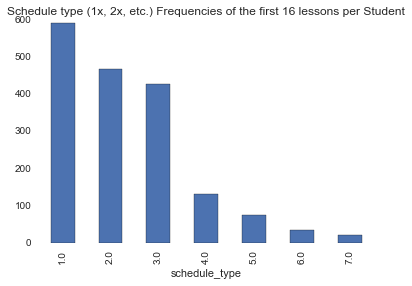

In [43]:
# Schedule type (1x, 2x, etc.) Frequencies of the first 16 lessons per Student
unique_user_summaries.groupby('schedule_type').size().plot(kind='bar',title='Schedule type (1x, 2x, etc.) Frequencies of the first 16 lessons per Student')

In [44]:
def retransform(cluster_centers):
        retransformed_cluster_centers = []
        
        for cluster_center in cluster_centers:
            retransformed_cluster_center = []
            
            cluster_center_length = len(cluster_center)
            cluster_center_dict = {}
            
            for index, feature in enumerate(cluster_center):
                val = 0
                
                if index % 2 == 0:
                    val = feature * 6.0
                    cluster_center_dict['l{}_day'.format(index / 2 + 1)] = [val]
                else:
                    val = feature * 23.75
                    cluster_center_dict['l{}_time'.format(index / 2 + 1)] = [val]
                

            retransformed_cluster_centers.append(cluster_center_dict)
        
        return retransformed_cluster_centers


def graph(df, user_id, title='', ax='not yet instantiated', color='red', prediction='', s=2.0):
    relevant_df = df[df.user_id == user_id]
        
    schedule_type = relevant_df['schedule_type'].values
    
    day = []
    time = []
    
    def add_jitter(day_array):
        return (np.random.rand(len(day_array)) - 0.5) / 4.0 + day_array
    
    for i in range(1,schedule_type + 1):
        day.append(relevant_df['l{}_day'.format(int(i))].values[0])
        time.append(relevant_df['l{}_time'.format(int(i))].values[0])
        
    
    dictionary = {
        'day_of_week': add_jitter(day),\
        'start_times': time\
    }
    
    new_df = pd.DataFrame(dictionary)
        
    if ax == 'not yet instantiated':
        ax = new_df.plot.scatter(x='day_of_week', y='start_times', color=color, alpha=1.0, title=title, s=s)
    else:
        ax = new_df.plot.scatter(x='day_of_week', y='start_times', ax=ax, color=color, alpha=1.0, title=title, s=s)

    ax.set_xlim([-0.5,6.5])
    ax.set_ylim([24.5,-0.5])
    return ax

In [45]:
def colors():
    return ['#ff0000',
        '#ff4000',
        '#ff8000',
        '#ffbf00',
        '#ffff00',
        '#bfff00',
        '#80ff00',
        '#40ff00',
        '#00ff00',
        '#00ff40',
        '#00ff80',
        '#00ffbf',
        '#00ffff',
        '#00bfff',
        '#0080ff',
        '#0040ff',
        '#0000ff',
        '#4000ff',
        '#8000ff',
        '#bf00ff',
        '#ff00ff',
        '#ff00bf',
        '#ff0080',
        '#ff0040',
        ]


In [46]:
def rgb(starting_shade_hex):
    color_without_the_pound_sign = starting_shade_hex[1:]
    
    red_hex = color_without_the_pound_sign[0:2]
    green_hex = color_without_the_pound_sign[2:4]
    blue_hex = color_without_the_pound_sign[4:]
    
    red_value = int(red_hex, 16)
    green_value = int(green_hex, 16)
    blue_value = int(blue_hex, 16)
    
    return {
        'r': red_value, 
        'g': green_value, 
        'b': blue_value
        }

def shades(r=0,g=0,b=0, num_shades=20):
    array_of_shades = []
    originals = np.array([r,g,b])
    to_subtract = originals / num_shades
    
    for i in range(0,num_shades):
        array_of_shades.append(originals - to_subtract * i)
        
    return array_of_shades

def remove_extra_characters(hex_value):
    regex = re.search('(?<=0x)[0-9A-Fa-f]+(?=L)', hex_value)
    return regex.group(0)

def ensure_two_characters(stripped_hex):
    if len(stripped_hex) == 1:
        return stripped_hex + '0'
    else:
        return stripped_hex

def hexify(shades):
    hexified_shades = []
    
    for shade in shades:
        accum = "#"
        for val in shade:
            accum += ensure_two_characters(remove_extra_characters(hex(val)))
        
        hexified_shades.append(accum)
    
    return hexified_shades

In [47]:
def graph_randoms(df_with_prediction, 
                  prediction='', 
                  prediction_label='prediction', 
                  num_samples=20, 
                  clusterer=None,
                  color='#ff0000',
                  schedule_type=2.0,
                  s=2.0):
    df = df_with_prediction[df_with_prediction[prediction_label] == prediction]
    
    def sample_size(df, num_random):
        if df['user_id'].size > num_random:
            return num_random
        else:
            return df['user_id'].size

        
    def abs_freq(local_df):
        return local_df.shape[0]
    def rel_freq(local_df, all_df):
        return round((float(abs_freq(local_df)) / all_df.shape[0] * 100.0), 2)
    
    def title(local_df, all_df, prediction):
        return "Cluster {}, n={}, {}%".format(prediction, abs_freq(local_df), rel_freq(local_df, all_df))
        
    user_ids = df['user_id'].sample(sample_size(df, num_samples)).values
    ax = 'not yet instantiated'
    rgb_dict = rgb(color)
    rgb_dict['num_shades'] = num_samples
    shade_values = hexify(shades(**rgb_dict))
    
    for idx, user_id in enumerate(user_ids): 
        ax = graph(df, user_id, s=s, ax=ax, color=shade_values[idx], title=title(df, df_with_prediction, prediction))
    
    
    if clusterer != None:
        cluster_centers = clusterer.cluster_centers_
        new_df_args = retransform(cluster_centers)[int(prediction)]
        new_df_args['user_id'] = 0
        new_df_args['schedule_type'] = schedule_type
        new_df = pd.DataFrame(new_df_args)
        graph(new_df, 0, s=s*3.0, ax=ax, color='black')

In [48]:
def get_distribution_frequency(df, prediction_label='prediction'):
    return df.groupby(prediction_label).size() / df.groupby(prediction_label).size().sum()
def get_distribution_count(df, prediction_label='prediction'):
    return df.groupby(prediction_label).size()

In [49]:
def graph_all(df_with_prediction, df_lesson_requests, prediction_label='prediction'):
    unique_prediction_values = df_with_prediction[prediction_label].unique()
   
    #fig, axes = plt.subplots(nrows=1, ncols=2)
       
    for prediction_idx, prediction in enumerate(unique_prediction_values):
        df_lrs = df_lesson_requests.copy()
        user_ids = df_with_prediction[df_with_prediction[prediction_label] == prediction].user_id

        df_lrs[df_lrs['user_id'].isin(user_ids)].plot.hexbin(x='weekday',\
                                                             y='start_time',\
                                                             gridsize=25,\
                                                            # ax=axes[0, prediction_idx]\
                                                            )
        #axes[0, prediction_idx].set_title(prediction_idx)


            

# Clustering 1x lessons

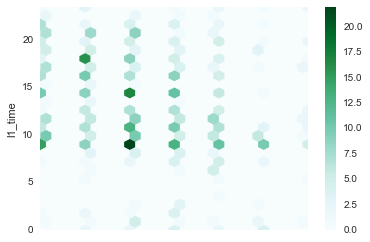

In [50]:
unique_user_summaries[unique_user_summaries.schedule_type == 1][['l1_day', 'l1_time']]\
    .plot.hexbin(x='l1_day', y='l1_time', gridsize=24)

In [51]:
one_lesson_schedule =  unique_user_summaries[unique_user_summaries.schedule_type == 1]
ols_two_cluster_KMeans = KMeans(n_clusters=2)
prediction = ols_two_cluster_KMeans.fit_predict(one_lesson_schedule[['l1_day',\
                                                              'l1_time',\
                                                             ]])
one_lesson_schedule['prediction'] = prediction

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [52]:
def hexbin_one_lesson_schedule(df, prediction=0, prediction_label='prediction'):
    size = df[prediction_label].unique().size - 1
    df[df[prediction_label] == prediction].plot.hexbin(x='l1_day', y='l1_time', gridsize=24, title='Prediction {}/{}'.format(prediction, size) )

In [53]:
def graph_hexbins(df, prediction_label='prediction'):
    size = df[prediction_label].unique().size
    for i in range(0,size):
        hexbin_one_lesson_schedule(df, prediction=i, prediction_label=prediction_label)

When k = 2, areas split between 0-12, 12-0

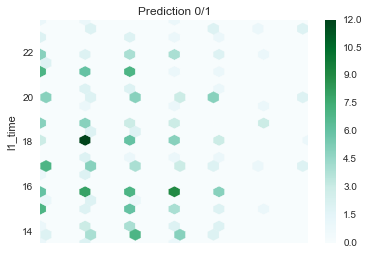

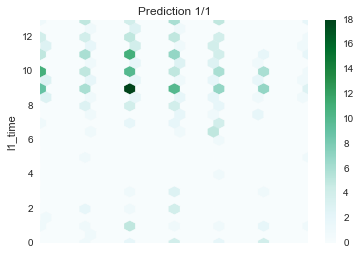

In [54]:
graph_hexbins(one_lesson_schedule)

## Clustering 2x Schedules

In [55]:
def sub_df_args(schedule_type):
    args = []
    for i in range(1, schedule_type + 1):
        args.append('scaled_l{}_day'.format(int(i)))
        args.append('scaled_l{}_time'.format(int(i)))
        
    return args

def cluster(df, n_clusters=2, schedule_type=2):
    clusterer = KMeans(n_clusters=n_clusters)
    sub_df = df[df.schedule_type == schedule_type] 
            
    sub_df["prediction_{}".format(n_clusters)] = clusterer.fit_predict(sub_df[sub_df_args(schedule_type)])
    
    print "Inertia: {}".format(clusterer.inertia_)
    
    return {'clusterer': clusterer, 'sub_df': sub_df}


def graph_clusters(df,
                   cluster_args=None, 
                   n_clusters=2, 
                   s=10, 
                   num_samples=200, 
                   schedule_type=2,
                   user_tz='Brasilia'):
    
    clusterer = cluster_args['clusterer']

    sub_df = df[(df.schedule_type == schedule_type) & (df.user_tz == user_tz)]

    sub_df["prediction_{}".format(n_clusters)] = clusterer.predict(sub_df[sub_df_args(schedule_type)])
    
    for i in range(0,n_clusters):
        graph_randoms(sub_df, 
                      s=s,
                      num_samples=num_samples,
                      clusterer=cluster_args['clusterer'], # why is this needed?
                      schedule_type=schedule_type,
                      prediction=i, 
                      color=colors()[i],
                      prediction_label='prediction_{}'.format(n_clusters))
    

    
def cluster_and_graph(df, n_clusters=2, schedule_type=2, num_samples=10, s=1.0, cluster_args=None):
    if not cluster_args:
        cluster_args = cluster(df, n_clusters=n_clusters, schedule_type=schedule_type)
        
        
    for i in range(0,n_clusters):
        graph_randoms(cluster_args['sub_df'], 
                      s=s,
                      num_samples=num_samples,
                      clusterer=cluster_args['clusterer'], # why is this needed?
                      schedule_type=schedule_type,
                      prediction=i, 
                      color=colors()[i],
                      prediction_label='prediction_{}'.format(n_clusters))
    
    #print retransform(cluster_args['clusterer'].cluster_centers_)
    return cluster_args

Inertia: 56.5917911871


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


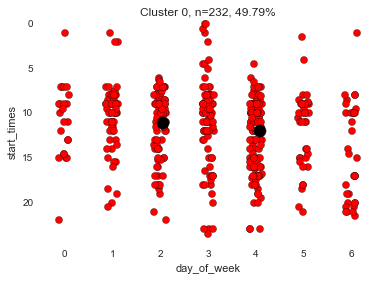

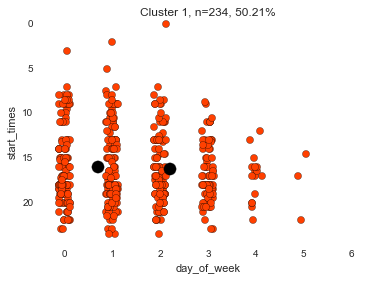

In [56]:
args_2x_2c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=500)

# Clustering all 2x schedules with 2 clusters

Inertia: 19.1030570125


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


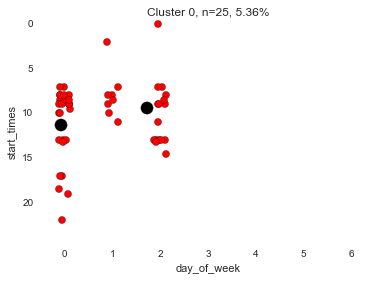

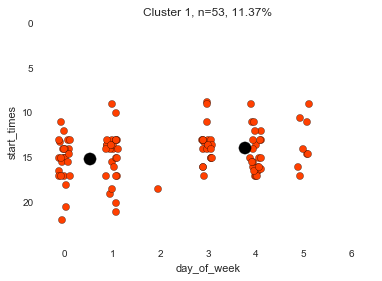

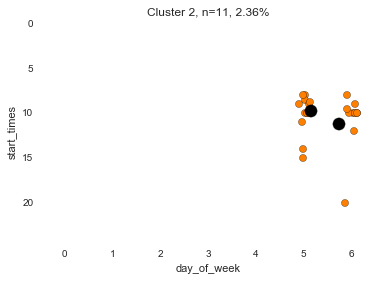

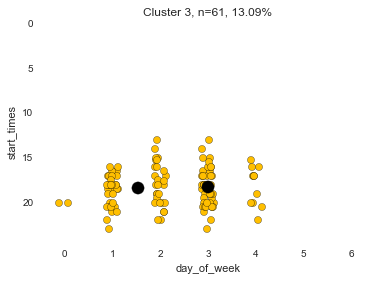

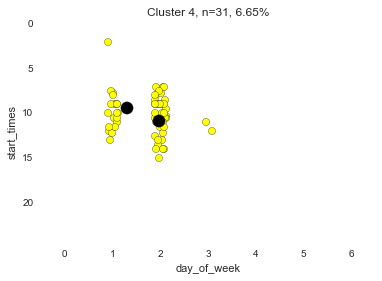

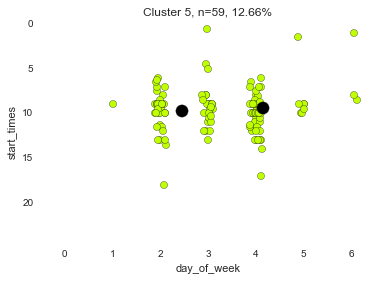

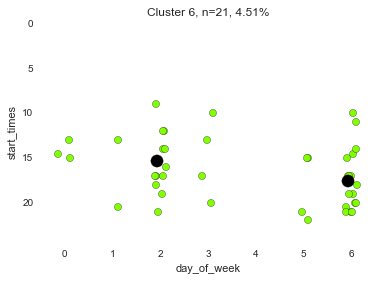

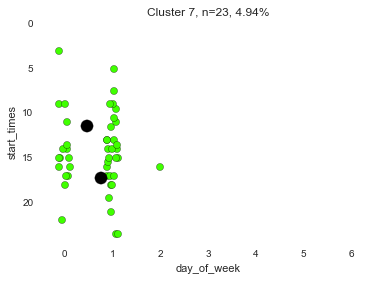

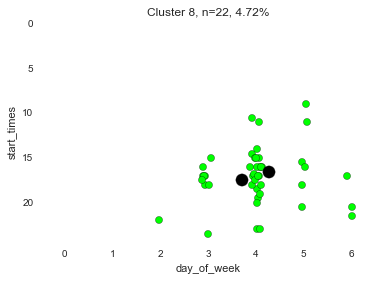

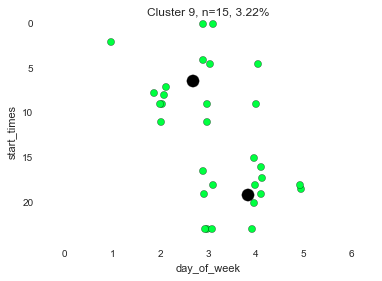

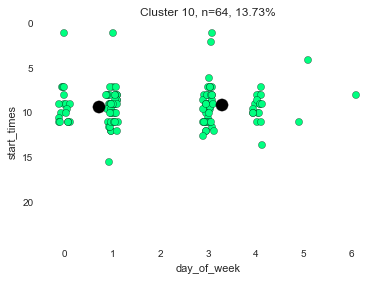

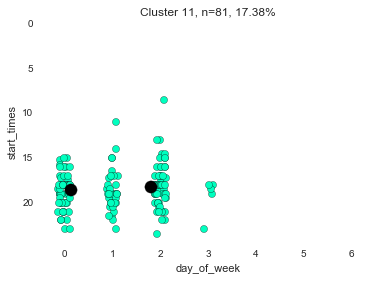

In [57]:
args_2x_12c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=12, 
                               s=50,
                               schedule_type=2,
                               num_samples=500)

Inertia: 44.9224291222


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


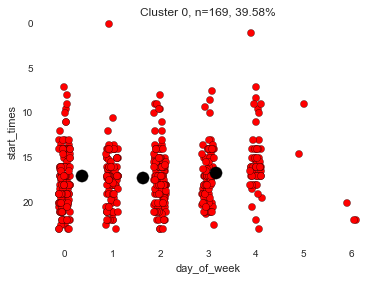

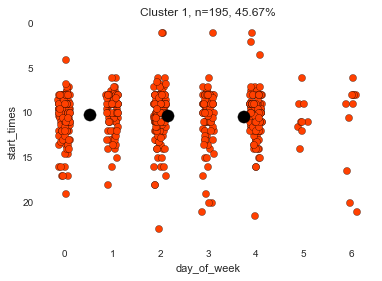

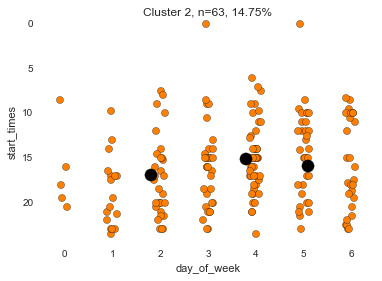

In [58]:
args_3x_3c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=3, 
                               s=50,
                               schedule_type=3,
                               num_samples=270)

Inertia: 25.9265956136


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


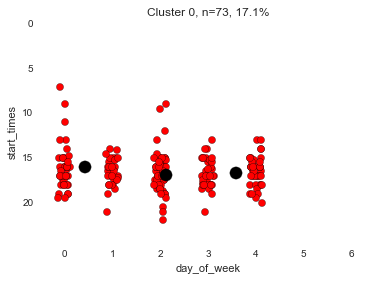

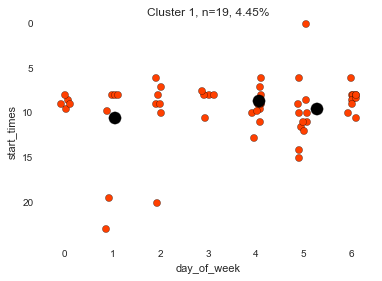

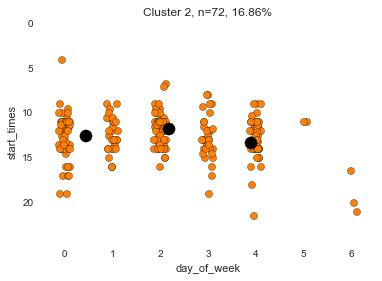

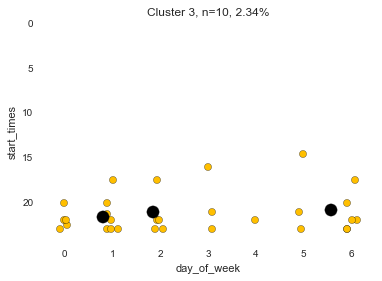

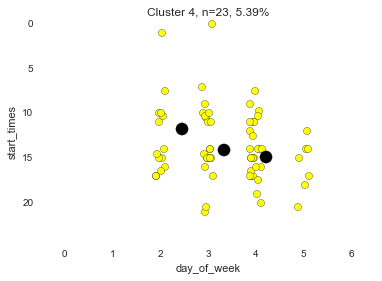

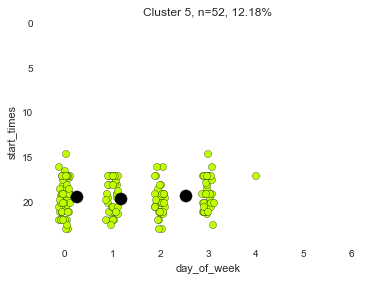

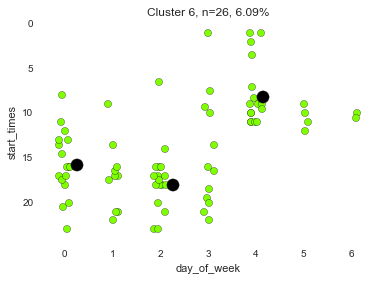

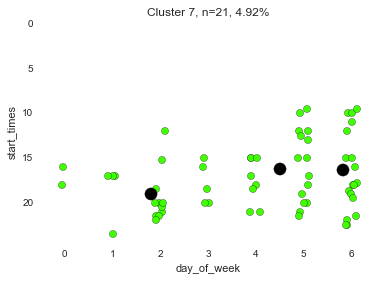

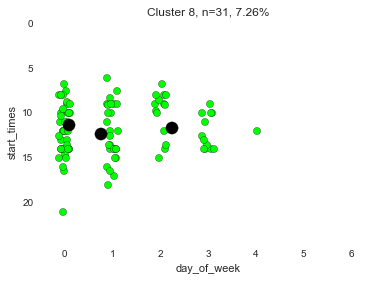

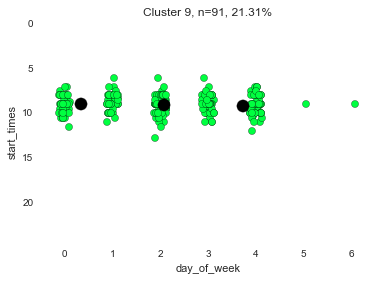

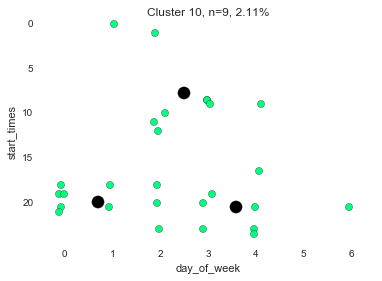

In [59]:
args_3x_10c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=11, 
                               s=50,
                               schedule_type=3,
                               num_samples=270)

Inertia: 24.8539795886


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


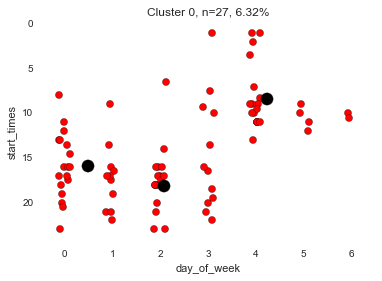

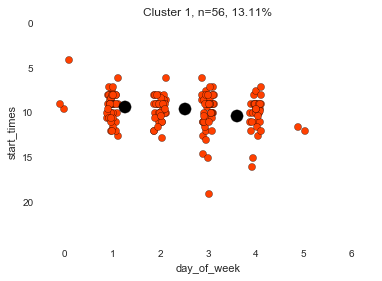

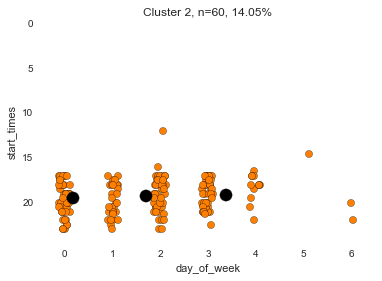

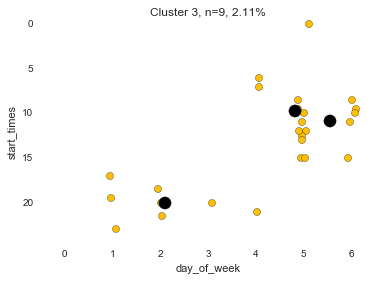

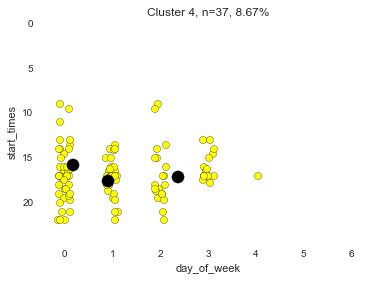

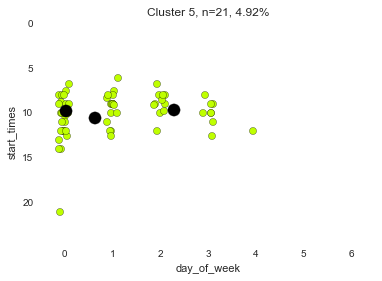

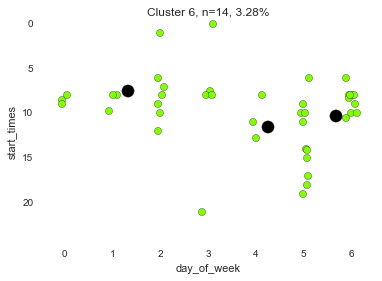

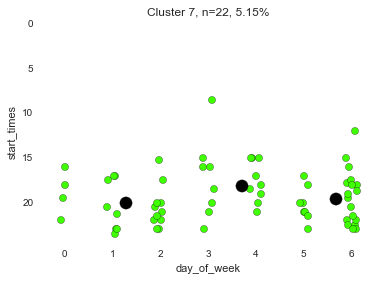

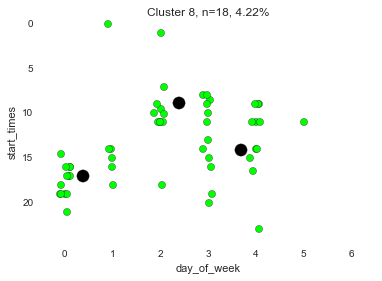

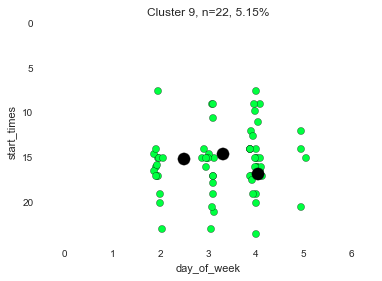

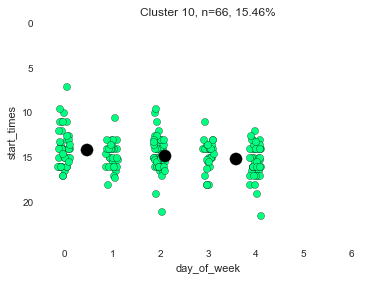

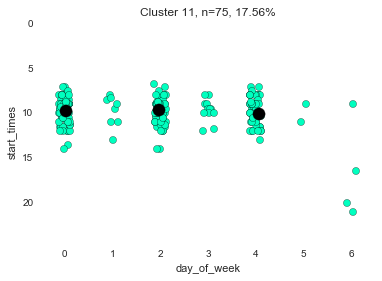

In [60]:
args_3x_16c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=12, 
                               s=50,
                               schedule_type=3,
                               num_samples=270)

Inertia: 30.4274662898


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'clusterer': KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
     verbose=0),
 'sub_df':       average_scaled_start_time  average_scaled_weekday  average_start_time  \
 6                      0.766316                0.244444           18.200000   
 9                      0.803509                0.263889           19.083333   
 32                     0.459474                0.220833           10.912500   
 41                     0.592391                0.349673           14.069281   
 52                     0.491228                0.722222           11.666667   
 60                     0.673684                0.555556           16.000000   
 62                     0.611529                0.285714           14.523810   
 64                     0.547368                0.333333           13.000000   
 86                     0.424349                0.437500           10.078299   
 94    

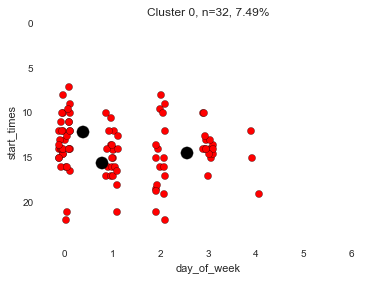

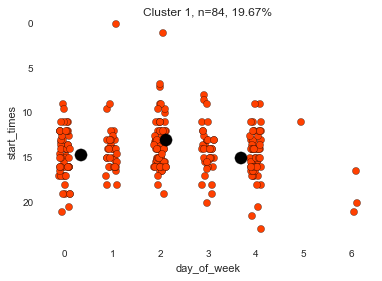

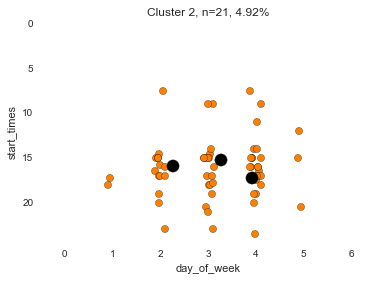

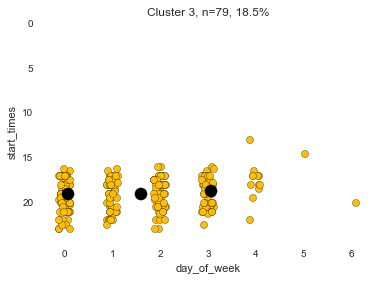

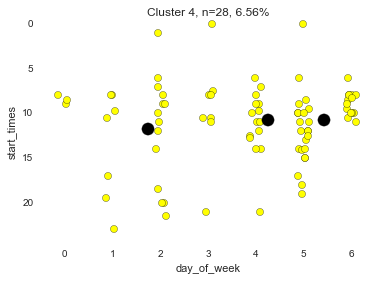

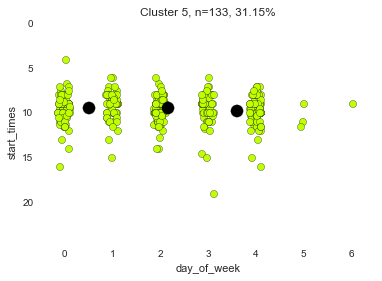

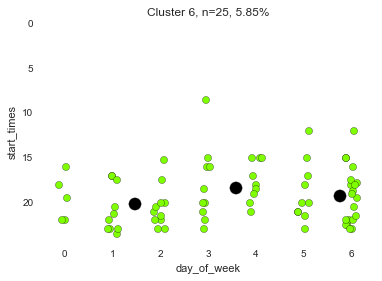

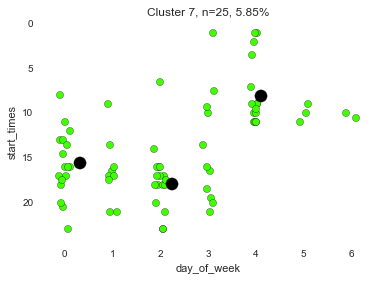

In [61]:
cluster_and_graph(unique_user_summaries, 
                               n_clusters=8, 
                               s=50,
                               schedule_type=3,
                               num_samples=270)

Inertia: 30.1652540017


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'clusterer': KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
     verbose=0),
 'sub_df':       average_scaled_start_time  average_scaled_weekday  average_start_time  \
 6                      0.766316                0.244444           18.200000   
 9                      0.803509                0.263889           19.083333   
 32                     0.459474                0.220833           10.912500   
 41                     0.592391                0.349673           14.069281   
 52                     0.491228                0.722222           11.666667   
 60                     0.673684                0.555556           16.000000   
 62                     0.611529                0.285714           14.523810   
 64                     0.547368                0.333333           13.000000   
 86                     0.424349                0.437500           10.078299   
 94    

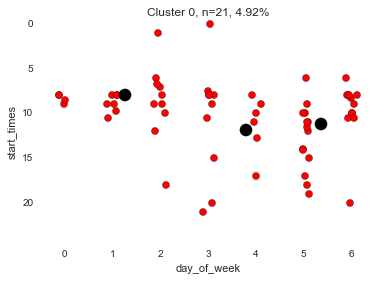

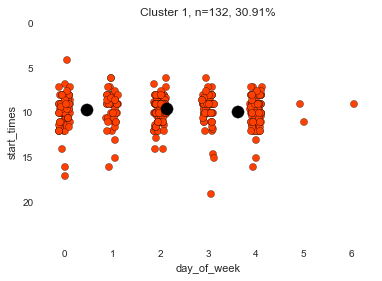

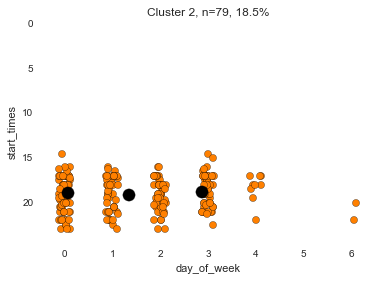

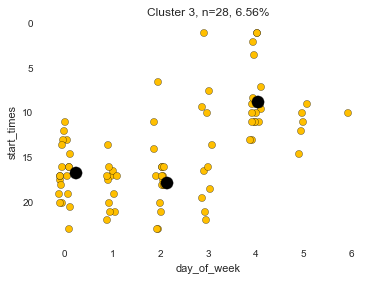

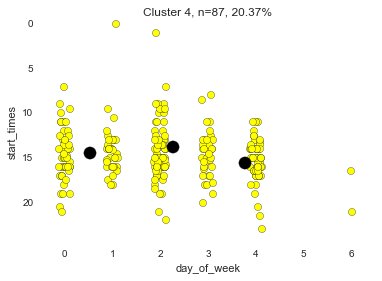

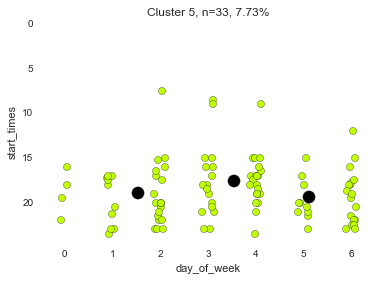

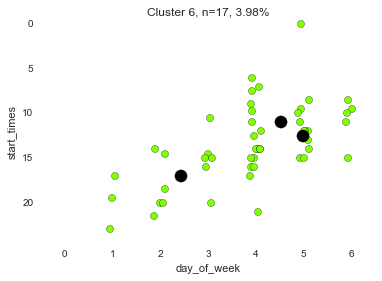

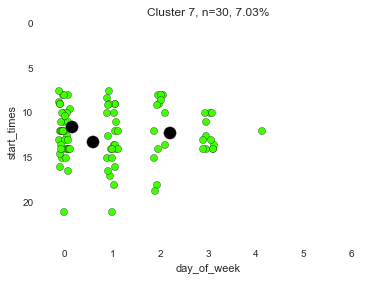

In [62]:
cluster_and_graph(unique_user_summaries, 
                               n_clusters=8, 
                               s=50,
                               schedule_type=3,
                               num_samples=270)

## Comparing 2x

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


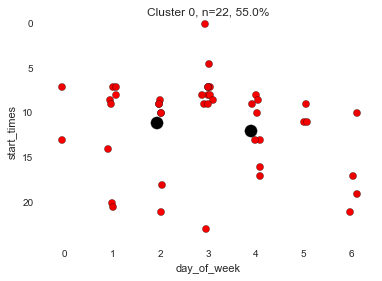

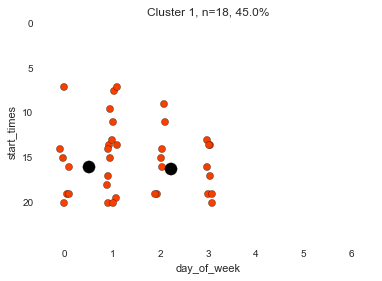

In [63]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Eastern Time (US & Canada)',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

In [64]:
unique_user_summaries[unique_user_summaries.schedule_type == 2].groupby('user_tz').size().sort_values(ascending=False)

user_tz
Pacific Time (US & Canada)     108
Brasilia                        75
Eastern Time (US & Canada)      40
Tokyo                           33
London                          28
New Delhi                       26
Chennai                         15
Central Time (US & Canada)      15
Mexico City                     13
Buenos Aires                    10
Jerusalem                        9
Mountain Time (US & Canada)      8
Seoul                            7
Paris                            6
Arizona                          4
Hong Kong                        4
Kolkata                          4
Madrid                           3
Berlin                           3
Bogota                           3
Dublin                           3
Guadalajara                      3
Rome                             2
Vienna                           2
Beijing                          2
Atlantic Time (Canada)           2
Mumbai                           2
Monterrey                        2
Caracas     

In [65]:
unique_user_summaries

,average_scaled_start_time,average_scaled_weekday,average_start_time,average_weekday,first_start_datetime,l1_day,l1_time,l2_day,l2_time,l3_day,...,scaled_l3_time,scaled_l3_day,scaled_l4_time,scaled_l4_day,scaled_l5_time,scaled_l5_day,scaled_l6_time,scaled_l6_day,scaled_l7_time,scaled_l7_day
0,0.521554,0.178571,12.386905,1.071429,2014-08-25 22:00:00-03:00,0,22.00,1.0,11.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.042105,0.833333,1.000000,5.000000,2014-03-15 01:00:00.904080,5,1.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.666667,0.378472,15.833333,2.270833,2014-03-13 01:00:00.090054,0,11.00,1.0,10.000000,3.0,...,0.042105,0.500000,0.000000,0.833333,NaN,NaN,NaN,NaN,NaN,NaN
3,0.381942,0.288889,9.071111,1.733333,2015-02-16 10:00:00-05:00,1,9.00,3.0,9.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.398297,0.461749,9.459563,2.770492,2014-03-12 22:00:00-04:00,4,9.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.842105,0.500000,20.000000,3.000000,2014-04-23 20:00:00.195294,2,20.00,4.0,20.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.766316,0.244444,18.200000,1.466667,2014-03-04 21:00:00.191380,1,21.00,1.0,22.000000,2.0,...,0.673684,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.273684,0.625000,6.500000,3.750000,2014-03-15 00:00:00.472331,5,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.042105,0.833333,1.000000,5.000000,2014-03-15 01:00:00.475870,5,1.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.803509,0.263889,19.083333,1.583333,2014-03-12 11:00:00.404259,0,23.00,2.0,23.000000,3.0,...,0.800000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
unique_user_summaries[unique_user_summaries.schedule_type == 3].groupby('user_tz').size().sort_values(ascending=False)

user_tz
Pacific Time (US & Canada)    178
Brasilia                       50
Tokyo                          28
Eastern Time (US & Canada)     28
Buenos Aires                   24
London                         20
Jerusalem                      10
New Delhi                      10
Mexico City                     9
Bogota                          7
Chennai                         6
Central Time (US & Canada)      6
Vienna                          5
Seoul                           5
Singapore                       5
Paris                           4
Madrid                          3
Rome                            3
Nairobi                         2
Berlin                          2
Dublin                          2
Monterrey                       2
Bern                            1
Central America                 1
Lima                            1
Guadalajara                     1
Hawaii                          1
Hong Kong                       1
UTC                             1
Mumbai

In [67]:
unique_user_summaries[unique_user_summaries.schedule_type == 4].groupby('user_tz').size().sort_values(ascending=False)

user_tz
Pacific Time (US & Canada)     27
Brasilia                       19
Eastern Time (US & Canada)     18
Tokyo                           9
Buenos Aires                    6
London                          6
Central Time (US & Canada)      5
Chennai                         5
Dublin                          5
Bogota                          4
New Delhi                       4
Guadalajara                     2
Jerusalem                       2
Mexico City                     2
Arizona                         2
Singapore                       1
Lima                            1
Mountain Time (US & Canada)     1
Mumbai                          1
Central America                 1
Osaka                           1
Rome                            1
Seoul                           1
Berlin                          1
Beijing                         1
dtype: int64

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


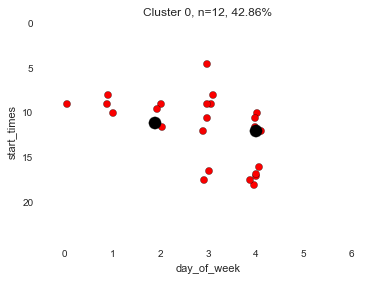

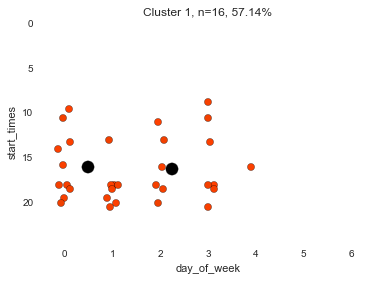

In [68]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='London',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


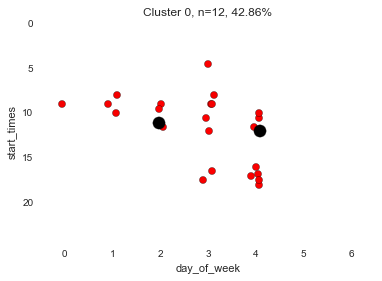

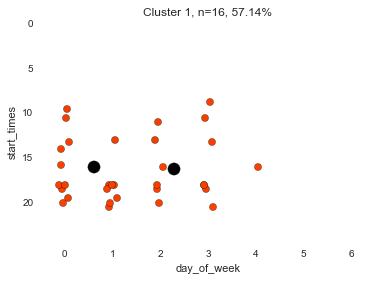

In [69]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='London',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


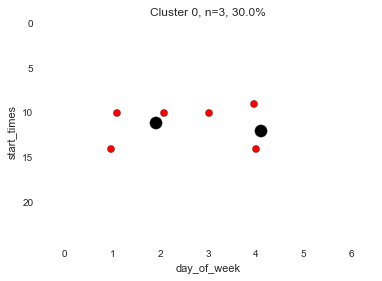

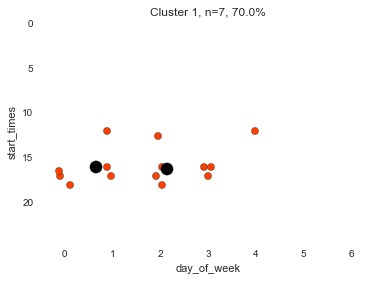

In [70]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Buenos Aires',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


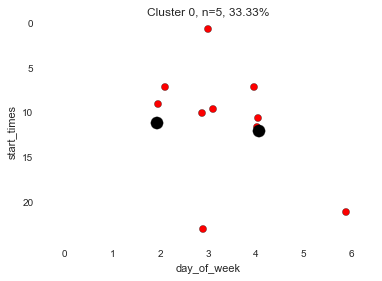

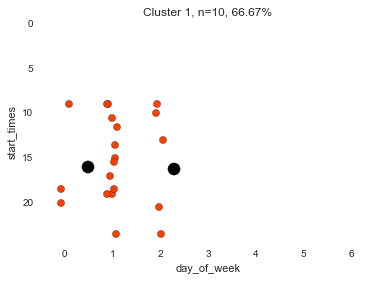

In [71]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Chennai',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


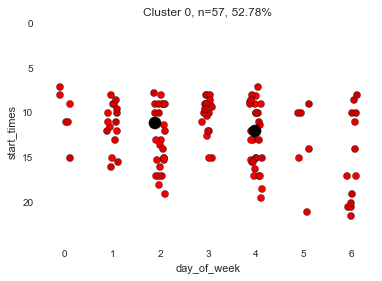

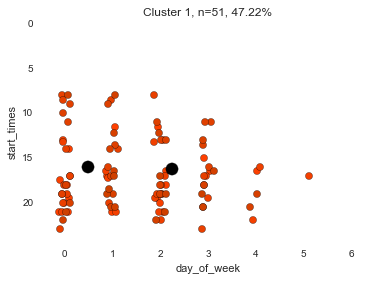

In [72]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Pacific Time (US & Canada)',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


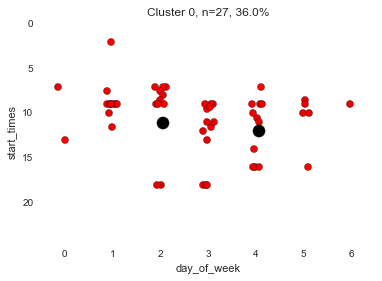

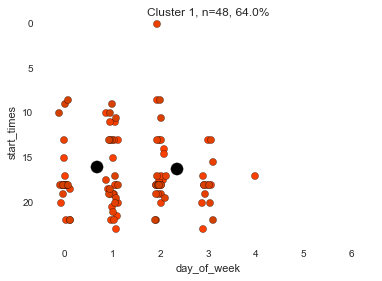

In [73]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Brasilia',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


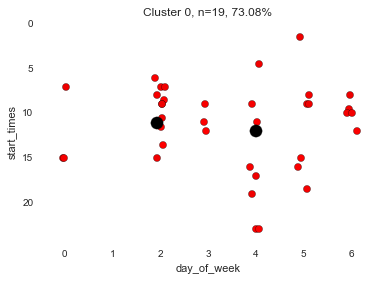

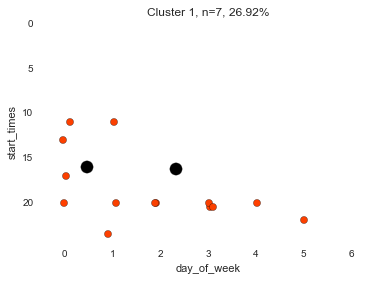

In [74]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='New Delhi',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


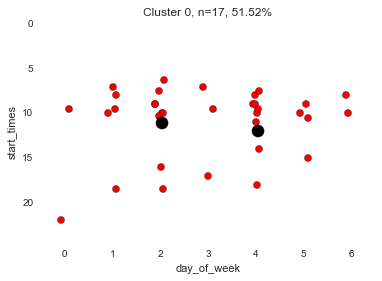

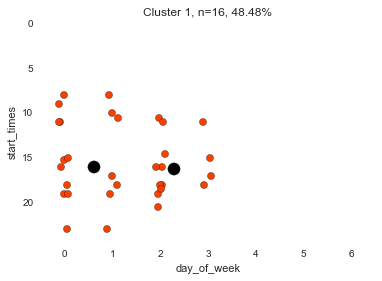

In [75]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Tokyo',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

# Eastern Time, 2x schedules, 2 clusters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


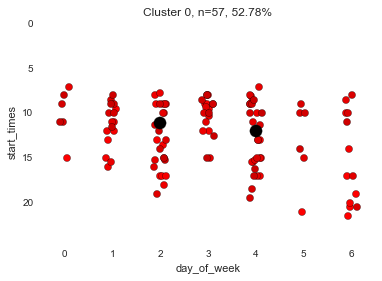

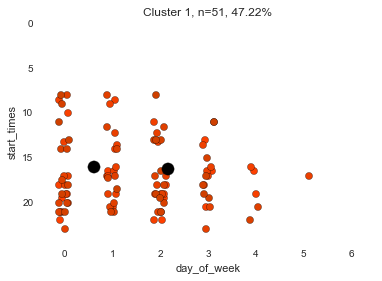

In [76]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Pacific Time (US & Canada)',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


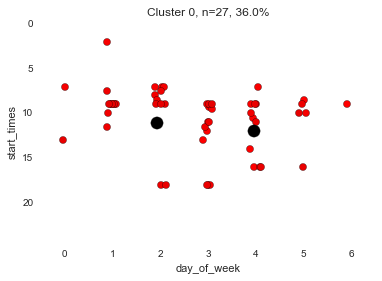

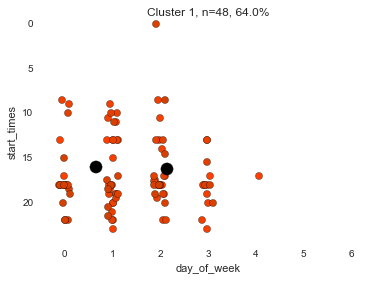

In [77]:
graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Brasilia',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


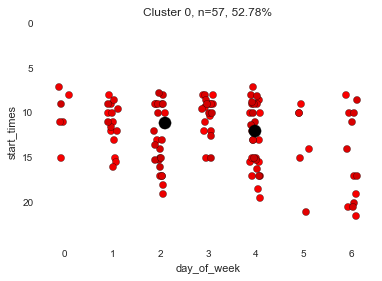

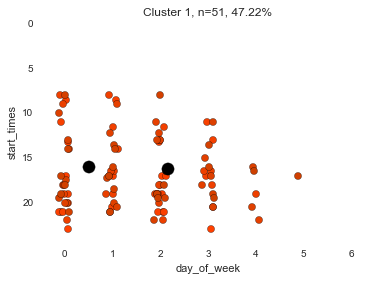

In [78]:
args_2x_2c_pacific = graph_clusters(unique_user_summaries, 
                               cluster_args=args_2x_2c,
                               user_tz='Pacific Time (US & Canada)',
                               n_clusters=2, 
                               s=50,
                               schedule_type=2,
                               num_samples=200)

In [79]:
chi2_contingency(results_2x)
# Statistically significant, p < 0.05

NameError: name 'results_2x' is not defined

In [ ]:
chi_input = pd.DataFrame({'top_cluster': [29, 69, 31, 17, 21, 13], 
              'bottom_cluster': [18, 57, 44, 7, 14, 11]})

In [ ]:
chi_input 

In [ ]:
chi_input.set_index([['Eastern (US & Canada)',
                'Pacific (US & Canada)',
                'Brasilia',
                'New Delhi',
                'Tokyo',
                'London']], inplace=True)

In [ ]:
chi_input_3x = pd.DataFrame({'top_cluster': [16, 87, 22, 6, 12, 13], 
              'bottom_cluster': [12, 70, 21, 8, 14, 6]})

In [ ]:
chi_input_3x.set_index([['Eastern (US & Canada)',
                'Pacific (US & Canada)',
                'Brasilia',
                'New Delhi',
                'Tokyo',
                'London']], inplace=True)

In [ ]:
sum_df = pd.DataFrame()
sum_df['bottom_cluster'] = chi_input['bottom_cluster'] + chi_input_3x['bottom_cluster']
sum_df['top_cluster'] = chi_input['top_cluster'] + chi_input_3x['top_cluster']

In [ ]:
sum_df

In [ ]:
chi_sq(sum_df)

In [ ]:
# Not significant
chi2_contingency(chi_input.values)

In [ ]:
# Not significant
chi2_contingency(chi_input_3x.values)

In [ ]:
# Not significant
chi2_contingency(sum_df.values)

In [ ]:
chi_input.index.values

In [ ]:
def totalize(t_2d):
        table_2d = t_2d.copy()
        table_2d['total'] = table_2d.sum(axis=1)
        row_totals = table_2d.sum()
        row_totals.name = 'total'
        table_2d = table_2d.append(row_totals)
        
        return table_2d
    
def normalize(table_2d):
    df_copy = table_2d.copy()
    total_column = df_copy.total
    cluster_columns = df_copy.columns[0:-1]
    
    for column in cluster_columns:
        df_copy['rel_{}'.format(column)] = df_copy[column] / total_column
    
    return df_copy

def chi_sq(t_2d):
    table_2d = t_2d.copy()
    
   
    
    def expected_freqs(table_2d):
        column_total_without_super_total = table_2d['total'][0:-1]
        
        dictionary = {}
        
        for column in table_2d.columns:
            dictionary[column] = column_total_without_super_total.values \
            * table_2d[column].ix['total'] \
            / float(table_2d['total'][-1])
            
        expected_freq_df = pd.DataFrame(dictionary).set_index(table_2d.ix[0:-1].index)
        row_total = expected_freq_df.sum()
        row_total.name = 'total'
        expected_freq_df = expected_freq_df.append(row_total)
        
        return expected_freq_df
       
    def flatten(df_with_totals):
        return df_with_totals[df_with_totals.columns[0:-1]].ix[0:-1].values.T.flatten()
    
    
    
    return ((flatten(totalize(table_2d)) - flatten(expected_freqs(totalize(table_2d)))) ** 2 \
        / flatten(expected_freqs(totalize(table_2d)))).sum()
    #return expected_freqs(totalize(table_2d))
    
#def simulate()

In [ ]:
normalize(totalize(chi_input))

In [ ]:
chi_sq(chi_input) 

In [ ]:
chi_input

In [ ]:
normalize(totalize(chi_input)).ix[:-1]

In [ ]:
def plot_membership(df, x=None, y=None, title=''):
    fig, ax = plt.subplots()

    subset = df[[x, y]].ix[:-1]
    subset.plot(x, y, kind='scatter', ax=ax, title=title)

    for k, v in subset.iterrows():
        ax.annotate(k, v)
        
plot_membership(normalize(totalize(chi_input)), 
                x='rel_bottom_cluster', 
                y='rel_top_cluster',
                title='Relative Frequencies of 2x Schedules by Timezone'
               )
plot_membership(normalize(totalize(chi_input_3x)), 
                x='rel_bottom_cluster', 
                y='rel_top_cluster',
                title='Relative Frequencies of 3x Schedules by Timezone'
               )

plot_membership(normalize(totalize(sum_df)), 
                x='rel_bottom_cluster', 
                y='rel_top_cluster',
                title='Relative Frequencies of Summed Schedules by Timezone'
               )

In [ ]:
args_2x_4c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=4, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_5c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=5, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_5c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=5, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_6c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=6, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_7c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=7, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_8c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=8, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_9c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=9, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_10c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=10, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_2x_11c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=11, 
                               schedule_type=2,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_2c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=2, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)


In [ ]:
args_3x_3c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=3, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_4c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=4, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_5c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=5, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_6c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=6, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_7c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=7, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_8c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=8, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_9c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=9, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_3x_10c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=10, 
                               schedule_type=3,
                               s=50,
                               num_samples=200)

In [ ]:
args_4x_2c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=2, 
                               schedule_type=4,
                               s=50,
                               num_samples=200)

In [ ]:
args_4x_3c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=3, 
                               schedule_type=4,
                               s=50,
                               num_samples=200)

In [ ]:
args_4x_4c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=4, 
                               schedule_type=4,
                               s=50,
                               num_samples=200)

In [ ]:
args_5x_2c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=2, 
                               schedule_type=5,
                               s=50,
                               num_samples=200)

In [ ]:
args_5x_3c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=3, 
                               schedule_type=5,
                               s=50,
                               num_samples=200)

In [ ]:
args_5x_4c = cluster_and_graph(unique_user_summaries, 
                               n_clusters=4, 
                               schedule_type=5,
                               s=50,
                               num_samples=200)

In [ ]:
def plot_centroids(clusterer):
    for index, center_array in enumerate(clusterer.cluster_centers_):
        colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'cyan', 'magenta']
        series = pd.DataFrame({'prediction ' + str(index) : center_array})
        plt.scatter(series.index, series, color=colors[index])

In [ ]:
# TODO: 
# graph the centroid!
# graph all predictions in one
#   - graph the centroids

In [ ]:
def graph_predictions_in_one_graph():
    plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)

In [ ]:
def confidence_interval(ratio, series):
    sorted_series = series.sort_values().values
    count = series.count()
    bound = (1.0-ratio) / 2.0
    lower_bound_index = int(bound * series.count())
    upper_bound_index = count - lower_bound_index
    
    return (sorted_series[lower_bound_index], sorted_series[upper_bound_index])

In [ ]:
# Why are they missing timezones?

In [ ]:
unique_user_summaries.columns

In [ ]:
unique_user_summaries.head(5)

In [ ]:
def build_general_start_time_vs_timezone_chi_table(df, schedule_type=2):
    user_timezones = []
    first_half = []
    second_half = []
    user_ids = df[df.schedule_type == schedule_type].user_id.values
    def maybe_append_then_get_index(row, user_timezones):

        user_tz = row['user_tz'].values[0]
        
        if user_tz not in user_timezones:
            user_timezones.append(user_tz)
            first_half.append(0.0)
            second_half.append(0.0)

        return user_timezones.index(user_tz) 


    for user_id in user_ids:
        row = df[df.user_id == user_id]
        
        for i in range(1, row['schedule_type'] + 1):
            timezone_index = maybe_append_then_get_index(row, user_timezones)

            # if in second half of the day
            if row['l{}_time'.format(i)].values[0] > 14.0:
                second_half[timezone_index] += 1.0
            else:
                first_half[timezone_index] += 1.0

    return pd.DataFrame({'first_half': first_half, 'second_half': second_half}).set_index([user_timezones])



    

In [ ]:
two_halves_table_2x = build_general_start_time_vs_timezone_chi_table(unique_user_summaries.dropna(subset=['user_tz']),\
                                                                    schedule_type=2)

In [ ]:
def filter_invalid_chi_rows(df):
    return df[(df.first_half >= 10.0) & (df.second_half >= 10.0)]

In [ ]:
filter_invalid_chi_rows(two_halves_table_2x)

In [ ]:
pickle.dump(unique_user_summaries, open( "unique_user_summaries.pkl", "wb" ))